# What is Data.py

So the goal is to build a generative model for our data. That is, given a few datapoints from some customer, how well does it match our own data distribution? What datapoints do we have that are most similar to the customers (so that we can provide them with new data)? How can we learn a few important features of our data so that it is easier to find similarities/trends and do analysis?

## Data.py is an entry-level attempt at this first question

From the existing datapoints, we estimate a mean and covariance from our data samples. Then, we just choose one data point from our sample (but this can ideally be set to a specific customer point that a customer gives us), and estimate the probability of that point coming from our data distribution (or how likely it is under our data distribution). This just gives us an estimate of how well that point fits our data.

# Bugs

So, it turns out that the covariance matrix is singular because the data matrix is ill-conditioned. Thus, data.py doesn't actually work right now. The data first needs to be featurized/extracted correctly into a proper data matrix, so that the covariance matrix is no longer singular. Then this approach should work.

# What's next

Try new methods for generative modeling. Clustering, and then doing some gaussian estimation. Or using a Gaussian Mixture Model. Or some type of deep generative modeling (probably should get the simple ones working first though). Also, if the customer gives us a distribution of datapoints, we can measure KL divergences (or any other distribution divergence measure, like a symmetric measure such as Shannon Jensen might be good) to measure how similar/dissimilar the distributions are. I think exploring along these lines is a good starting point.

In [175]:
import numpy as np 
import pandas as pd 
import os
from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [176]:
class DataManager:
    DATA_FOLDER = 'data/'
    
    def __init__(self):
        self.fake2realid = {}
        self.real2fakeid = {}
        self._load_user_data()
        self._load_data_matrix()
        self._preprocess_data_matrix()
        
    def get_data_matrix(self):
        return self._data_matrix
        
    def get_user_data(self):
        return self._user_data
        
    def _load_user_data(self):
        user_data = {}
        for filename in os.listdir(self.DATA_FOLDER):
            df = pd.read_csv(self.DATA_FOLDER + filename)
            df = df._get_numeric_data()
            for id_, samples in df.groupby('Id'):
                if id_ not in user_data:
                    user_data[id_] = []
                for sample in samples.as_matrix():
                    user_data[id_].extend(sample[1:]) # remove id
        self._user_data = user_data

    def _load_data_matrix(self):   
        data_matrix = []
        i = 0
        for id_, data in self._user_data.items():
            self.fake2realid[i] = id_
            self.real2fakeid[id_] = i
            data_matrix.append(np.array([i] + data))
            i += 1
        #data_matrix = np.array(data_matrix)
        self._data_matrix = data_matrix
        
    def _preprocess_data_matrix(self):
        pass

In [177]:
data_manager = DataManager()
data_matrix = data_manager.get_data_matrix()

In [178]:
df = pd.DataFrame(data_matrix)
df = df.fillna(0)
#df

In [179]:
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
#df_normalized

[ 129.74706989   93.62941561]
[  4.30631961e-16   5.51747200e-16]


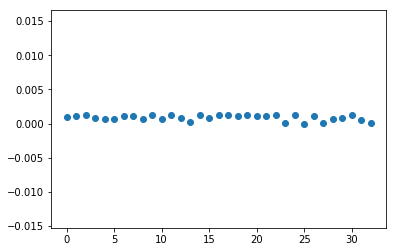

In [217]:
data_matrix2 = df_normalized.as_matrix()

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(data_matrix2)

mean = reduced_X.mean(axis=0)
covariance = np.cov(reduced_X.T)

print(np.linalg.svd(covariance)[1])
print(mean)

#new_point = reduced_X[0] # SET TO NEW INPUT POINT
prob = []
for pt in reduced_X:
    new_prob = multivariate_normal.pdf(pt, mean=mean, cov=covariance)
    prob.append(new_prob)
    #print('probability of new point under existing data:', new_prob * 100)

import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(prob))], prob)
plt.show()